# Model reduction and foliation in a nonlinear oscillator chain 

We now analyze the dynamics of a chain of oscillators, which has been treated in the SSMLearn package of Cenedese et al. 2022. 

Denoting the positions of the oscillators as $q_{i}$ for $i=1,...,5,$ we assume that the springs and dampers are linear, except for the first oscillator. The non-dimensionalized equations of motion can be written as 

$$
\mathbf{M\ddot{\mathbf{q}}}+\mathbf{C}\dot{\mathbf{q}}+\mathbf{K}\mathbf{q}+\mathbf{f}(\mathbf{q},\dot{\mathbf{q}})=\mathbf{0},
$$
where $\mathbf{M}=\mathbf{I}$; the springs have the same linear stiffness $k=1$ which is encoded in $\mathbf{K}$ via nearest-neighbor coupling. 
The damping is assumed to be proportional, i.e., we specifically set 
$$
\mathbf{C}=0.002\mathbf{M}+0.005\mathbf{K}.
$$
    

The trajectories have been generated by ```SSMLearn``` and are available at https://github.com/haller-group/SSMLearn

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from joblib import load, dump

Here we fit a full linearization to trajectories after a convergence to a 4D SSM has taken place. 

For the 4D SSM, we assume a linear parametrization. Following https://github.com/haller-group/SSMLearn, the tangent space is approximated via DMD

In [5]:
data_dictionary = load('data/oscillator_chain.data')
projector = data_dictionary['projector']
data_train = data_dictionary['data_train']
data_test = data_dictionary['data_test']
time_sample = data_dictionary['time_sampling']

The first 3 coordinates of the reduced phase can be visualized as

In [6]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 12,"font.family": "serif",})

Text(0.5, 0, '$\\varphi_3$')

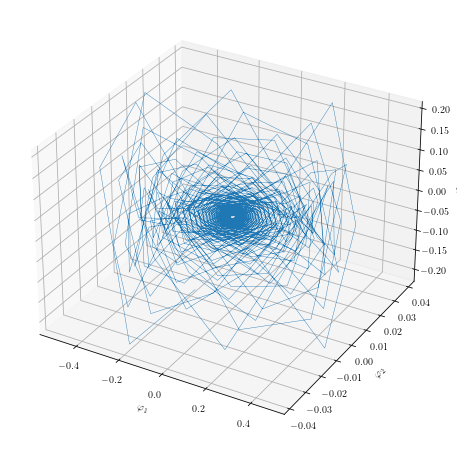

In [7]:
reduced_coordinates = projector@data_train[0]
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection = '3d')
ax.plot(reduced_coordinates[0,:], reduced_coordinates[1,:], reduced_coordinates[2,:], linewidth =0.4)
ax.set_xlabel('$\\varphi_1$')
ax.set_ylabel('$\\varphi_2$')
ax.set_zlabel('$\\varphi_3$')

In [8]:
# import distinctipy 
# colors2 = distinctipy.get_colors(9, n_attempts = 7000, rng = 1, colorblind_type='Tritanopia')
# distinctipy.color_swatch(colors2)

In [9]:
reduced_coords_train = [projector @ y for y in data_train]


In [10]:
reduced_coord_test = [projector @ y for y in [data_test]]

In [11]:
from data_driven_linearization.dmd import dmd
from data_driven_linearization.edmd import edmd



In [12]:
Dmd = dmd(reduced_coords_train)
init_matrix = Dmd.coef_

In [13]:
teval = time_sample

## Fitting the DDL model

In [14]:
from data_driven_linearization.linearization import DataDrivenLinearization
from data_driven_linearization.differentiation_utils import differentiate_model_symbolic

In [15]:
%%time
degree = 3
dimension = 4
d = DataDrivenLinearization(dimension, degree = degree)
d.fit(reduced_coords_train, alpha = 0, method= 'with_inverse',
      initial_matrix = init_matrix,
      initial_transformation='zero', verbose = True,
      method_optimization = 'trf')


Initial cost:  0.017763967666570055
     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-3.538e-04  1.182e-04 ...  1.698e-08  2.471e-08]
           x: [ 8.108e-01  7.290e+00 ...  2.083e-01  3.880e+00]
        cost: 0.0010826899395252004
         jac: [[ 1.282e-01 -3.598e-02 ...  0.000e+00  0.000e+00]
               [-1.677e-01 -3.799e-02 ...  0.000e+00  0.000e+00]
               ...
               [ 0.000e+00  0.000e+00 ...  4.547e-13  0.000e+00]
               [ 0.000e+00  0.000e+00 ...  0.000e+00 -4.688e-13]]
        grad: [ 9.820e-10 -9.259e-12 ...  1.130e-11  1.134e-11]
  optimality: 5.382977450880255e-09
 active_mask: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
        nfev: 17
        njev: 17
Final cost:  0.0021653798790504004
CPU times: user 30.5 s, sys: 817 ms, total: 31.3 s
Wall time: 31.2 s


In [16]:
v, w = np.linalg.eig(d.linear_model)

dt = (teval[1] - teval[0])
Diag_cont_init = np.diag(np.log(v)/dt)

Cont_non_diag = np.real(w@Diag_cont_init@np.linalg.inv(w))


In [17]:
pred = d.predict(reduced_coords_train[0][:,0], reduced_coords_train[0].shape[1]-1)

In [18]:
predicted_ddl = np.array(pred)


In [19]:
def simulate_unforced(t, x):
    xx = x.reshape(-1,1)
    return Cont_non_diag @ x

In [20]:
tmax = teval[-1]

In [21]:
transformed = d.transform(reduced_coord_test[0])

In [22]:
from scipy.integrate import solve_ivp

In [23]:
pred = solve_ivp(simulate_unforced, [0, tmax], transformed[:,0], t_eval = teval,  method = 'DOP853')
untrf_pred = d.inverse_transform(pred.y)


## Computing the SSM

The eigenspaces are not necessarily normal, therefore we compute the SSM of the linearized system as the slow subspace spanned by the slow eigenvectors.

In [24]:
%matplotlib widget

In [25]:
fraction1 = np.linspace(-0.5, 0.5, 30)
fraction2 = np.linspace(-0.5, 0.5, 30)

F1, F2 = np.meshgrid(fraction1, fraction2)

In [26]:
coords = np.vstack((F1.ravel(),F2.ravel()))

In [27]:
linear_ssmplane_coords = coords[0,:].reshape((900,1))*w[:,0].real + coords[1,:].reshape((900,1))*w[:,0].imag

In [28]:
nonlinear_ssm = [d.inverse_transform(s.reshape(-1,1)) for s in linear_ssmplane_coords]

In [29]:
nonlinear_ssm = np.squeeze(np.array(nonlinear_ssm))

In [30]:
import matplotlib.tri as mtri
tri = mtri.Triangulation(F1.ravel(), F2.ravel())

In [31]:
leading_eigval = np.log(v[0])/dt

In [32]:
reduced_mtx = np.array([[leading_eigval.real,leading_eigval.imag],
                        [-leading_eigval.imag,leading_eigval.real]])

In [33]:
diagonalizing_transform = np.vstack((w[:,0].real, w[:,0].imag, w[:,2].real,w[:,2].imag)).T

In [34]:
Diagonalized = np.linalg.inv(diagonalizing_transform)@Cont_non_diag@diagonalizing_transform


In [35]:
Diagonalized_reduced = Diagonalized[:2,:2]

In [36]:
def reduced_model(t,x):
    return Diagonalized_reduced@x

In [37]:
def predict_on_2DSSM(x, teval):
    x_linearized = np.squeeze(d.transform(x.reshape(-1,1)))
    x_linearized_projected = (np.linalg.inv(diagonalizing_transform)@x_linearized)[:2]
    sol = solve_ivp(reduced_model, [teval[0], teval[-1]], x_linearized_projected, t_eval = teval)
    sol_lift = diagonalizing_transform@(np.concatenate((sol.y,sol.y*0))) 
    
    return d.inverse_transform(sol_lift)
    

In [38]:
ssm_2d_prediction = predict_on_2DSSM(reduced_coord_test[0][:,0], teval)

In [39]:
colors2 = [(0.03678484251536762, 0.6179966849702221, 0.9739358488787938),
 (0.9973991938671649, 0.271843841793703, 0.3312661650034482),
 (0.46923921134665403, 0.05321353602065504, 0.7589105321169408),
 (0.6518372201847867, 0.02303925652524519, 0.11509491725842236),
(0.2801795133081738, 0.5636756117295652, 0.2994640928542739)]

Text(0, 0.5, 'Reduced coordinate')

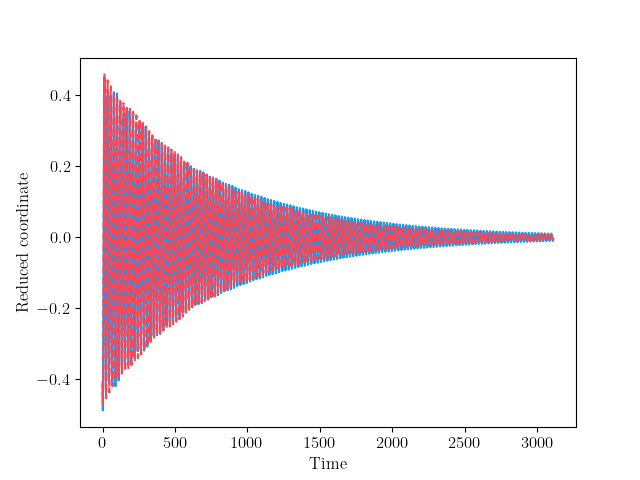

In [40]:
plt.figure()
plt.plot(teval, reduced_coord_test[0][0,:], '-', c=colors2[0])
plt.plot(teval, ssm_2d_prediction[0,:], '--', c=colors2[1])
plt.xlabel('Time')
plt.ylabel('Reduced coordinate')


In the linear phase space, the leaves of the foliation are 

$$
(\gamma_{1,0},\gamma_{2,0}, x, y) 
$$

for a fixed $(\gamma_{1,0},\gamma_{2,0})$

To simplify the visualization, let's fix $\gamma_{2,0}=0$

In [41]:
fraction1_leaves = np.linspace(-1, 1, 30)
fraction2_leaves = np.linspace(-1,1, 30)

F1_l, F2_l = np.meshgrid(fraction1_leaves, fraction2_leaves)
coords_leaves = np.vstack((F1_l.ravel(),F2_l.ravel()))

In [42]:
fraction1 = np.linspace(-0.5, 0.5, 1000)

leaves_linear = [ np.vstack((coords_leaves[0,:]*0 + x0, coords_leaves[0,:]*0,coords_leaves)) for x0 in fraction1]

In [43]:
leaves_linear_transformed = [diagonalizing_transform@x for x in leaves_linear]

In [44]:
leaves_nonlinear = [d.inverse_transform(x) for  x in leaves_linear_transformed]

In [45]:
reduced_coords_linear = [d.transform(p) for p in reduced_coords_train]

In [46]:
x_linearized_projected = [(np.linalg.inv(diagonalizing_transform)@r)[:2] for r in reduced_coords_linear]
x_linearized_untransformed = [diagonalizing_transform@(np.concatenate((r,r*0))) for r in x_linearized_projected ]

In [47]:
x_linearized_untransformed = np.squeeze(d.transform(ssm_2d_prediction))

In [49]:
linear_data = {}
linear_data['leaves_linear'] = leaves_linear_transformed
linear_data['linear_ssm'] = linear_ssmplane_coords
linear_data['linear_trajectory'] = reduced_coords_linear
linear_data['linear_projected'] = x_linearized_untransformed
nonlinear_data = {}
nonlinear_data['leaves_nonlinear'] = leaves_nonlinear
nonlinear_data['nonlinear_ssm'] = nonlinear_ssm
nonlinear_data['nonlinear_trajectory'] = reduced_coords_train
nonlinear_data['nonlinear_projected'] = ssm_2d_prediction


Text(0.5, 0, '$\\gamma_3$')

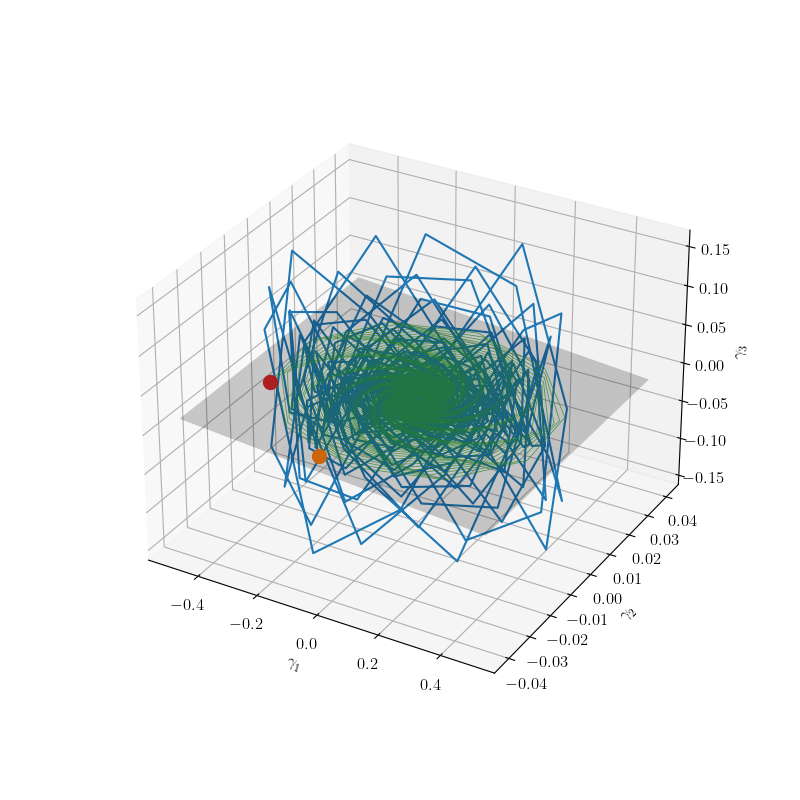

In [50]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection = '3d')
ax.plot_trisurf(linear_ssmplane_coords[:,0],linear_ssmplane_coords[:,1],linear_ssmplane_coords[:,2], triangles=tri.triangles, color='black', alpha = 0.2)

init = 30
ax.plot(reduced_coords_linear[0][0,init:], reduced_coords_linear[0][1,init:],reduced_coords_linear[0][2,init:])
ax.plot(reduced_coords_linear[0][0,init], reduced_coords_linear[0][1,init],reduced_coords_linear[0][2,init], 'o', markersize = 10)
ax.plot(x_linearized_untransformed[0,init:], x_linearized_untransformed[1,init:],x_linearized_untransformed[2,init:], '-', linewidth = 0.6, alpha = 0.7)
ax.plot(x_linearized_untransformed[0,init], x_linearized_untransformed[1,init],x_linearized_untransformed[2,init], 'o', markersize = 10)

ax.set_xlabel('$\\gamma_1$')
ax.set_ylabel('$\\gamma_2$')
ax.set_zlabel('$\\gamma_3$')


## Reduced-order model based on DMD and EDMD


In [51]:
figure_ = {}
figure_['reduced_coords_train'] = reduced_coords_train
figure_['reduced_coords_test'] = reduced_coord_test

figure_['ddl_on_2d_ssm'] = ssm_2d_prediction
figure_['ddl_on_4d_ssm'] = untrf_pred
figure_['teval'] = teval

In [52]:
deg = 4
Dmd = dmd(reduced_coords_train)
Edmd = edmd(reduced_coords_train, degree = deg)

In [53]:
from sklearn.preprocessing import PolynomialFeatures

In [54]:

nonlin_features = PolynomialFeatures(degree = 4, 
                                     include_bias = False).fit_transform(reduced_coord_test[0].T)


In [55]:
def iterate(x0, A, n):
    iterates = [x0]
    for i in range(n):
        iterates.append(A@iterates[-1])
    return iterates

In [56]:
dmd_pred_4d = np.array(iterate(reduced_coord_test[0][:,0],
                            Dmd.coef_, 
                            figure_['teval'].shape[0] -1))

edmd_pred_4d = np.array(iterate(nonlin_features[0,:],
                            Edmd.coef_, 
                            figure_['teval'].shape[0] -1))



In [57]:
figure_['dmd_4d'] = dmd_pred_4d.T
figure_['edmd_4d'] = edmd_pred_4d.T

In [58]:
deg = 3
Dmd = dmd([r[:2, :] for r in reduced_coords_train])
Edmd = edmd([r[:2, :] for r in reduced_coords_train], degree = deg)

In [59]:
nonlin_features = PolynomialFeatures(degree = 3,
                                     include_bias = False).fit_transform(reduced_coord_test[0][:2, :].T)


In [60]:
dmd_pred_2d = np.array(iterate(reduced_coord_test[0][:2,0],
                            Dmd.coef_, 
                            figure_['teval'].shape[0] -1))

edmd_pred_2d = np.array(iterate(nonlin_features[0,:],
                            Edmd.coef_, 
                            figure_['teval'].shape[0] -1))



In [61]:
figure_['dmd_2d'] = dmd_pred_2d.T
figure_['edmd_2d'] = edmd_pred_2d.T

## Create the comparison figure

In [62]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 14,"font.family": "serif",})

In [64]:
%matplotlib inline

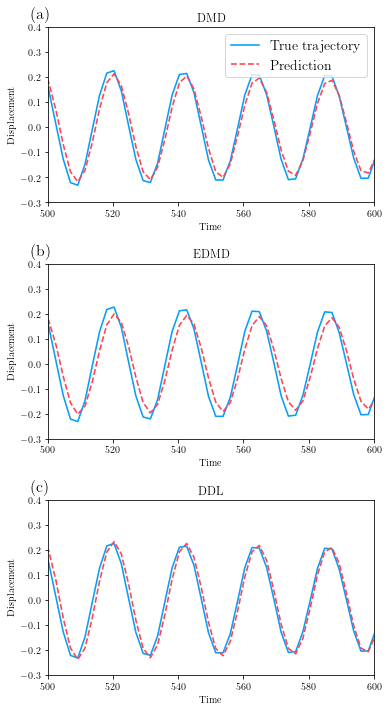

In [65]:
fig, axes = plt.subplots(ncols = 1, nrows = 3, figsize = (5.5,10))

axes[0].plot(figure_['teval'], figure_['reduced_coords_test'][0][0,:],  '-',
               linewidth = 1.6,  c=colors2[0], label = 'True trajectory')

axes[0].plot(figure_['teval'], figure_['dmd_2d'][0,:], '--', 
               linewidth = 1.6, alpha = 1, c=colors2[1], label = 'Prediction')

axes[0].set_title('DMD')


axes[1].plot(figure_['teval'], figure_['reduced_coords_test'][0][0,:],  '-',
               linewidth = 1.6,  c=colors2[0])

axes[1].plot(figure_['teval'], figure_['edmd_2d'][0,:], '--', 
               linewidth = 1.6, alpha = 1, c=colors2[1])
axes[1].set_title('EDMD')


axes[2].plot(figure_['teval'], figure_['reduced_coords_test'][0][0,:],  '-',
               linewidth = 1.6,  c=colors2[0])

axes[2].plot(figure_['teval'], figure_['ddl_on_2d_ssm'][0,:], '--', 
               linewidth = 1.6, alpha = 1, c=colors2[1])
axes[2].set_title('DDL')


for a in axes.ravel():
    a.set_xlim(500, 600)
    
    
axes[0].legend(fontsize = 14, loc = 'upper right')
fig.tight_layout()
for a in axes:
    
    a.set_ylabel('Displacement')


for i in range(3):
    axes[i].set_xlabel('Time')
    axes[i].set_ylim(-0.3,0.4)
    
    
    
labels = ['(a)', '(b)', '(c)']
for a,l in zip(axes.ravel(), labels):
    a.text(-0.05, 1.05, l,transform=a.transAxes, fontsize = 16)
fig.tight_layout()
plt.savefig("figure9.pdf", bbox_inches='tight')

Save figure data

In [66]:
dump(figure_, 'saved_models/figure_9.data')

['saved_models/figure_9.data']